In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import jax
jax.config.update("jax_enable_x64", True)

from jax import vmap, grad, random, jit, tree_map
import jax.numpy as jnp
from inference.MP_Inference import lds_inference, lds_inference_sequential, lds_inference_homog, hmm_inference, lds_to_hmm_mf, hmm_to_lds_mf

import pickle
import time

# Generate synethic parameters

In [2]:
os.makedirs("saved_models", exist_ok=True)

#### Create recognition potentials to parameterize Gaussian $\hat{\ell}_\phi(z|x)$

In [3]:
from models.VAE import Encoder
N = 100
D = 5

In [4]:
rng = random.PRNGKey(47)
init, inp = random.split(rng, 2)
model = Encoder(D)
params = model.init({'params': init}, jnp.ones((N,20)))
recog_potentials = model.apply(params, random.normal(inp, (N,20)), mutable=['batch_stats'])[0]

#### Create graphical model parameters for an LDS

In [5]:
from models.SVAE_LDS import PGM_LDS
rng = random.PRNGKey(4747)
model = PGM_LDS(D, inf32=False)
params = model.init({'params': init}, recog_potentials, rng)
pgm_potentials = model.apply(params, recog_potentials, method=PGM_LDS.expected_params)[0]

In [6]:
with open("saved_models/lds.pkl", 'wb') as f:
    pickle.dump((recog_potentials, pgm_potentials), f)

#### Create graphical model parameters for an SLDS

In [7]:
from models.SVAE_SLDS import PGM_SLDS
from inference.SLDS_Inference import slds_inference_itersolve
K = 4

In [8]:
rng = random.PRNGKey(4747)
model = PGM_SLDS(D, K, slds_inference_itersolve, inf32=False)
params = model.init({'params': init}, recog_potentials, rng, rng)
pgm_potentials = model.apply(params, method=PGM_SLDS.expected_params)[0]

Compute the endpoints of inner optimization

In [9]:
gaus_expected_stats, cat_expected_stats = slds_inference_itersolve(recog_potentials, *pgm_potentials, rng)
gaus_natparam = hmm_to_lds_mf(cat_expected_stats, pgm_potentials[0], 0.)[0]
cat_natparam = lds_to_hmm_mf(gaus_expected_stats, pgm_potentials[0])

In [10]:
with open("saved_models/slds.pkl", 'wb') as f:
    pickle.dump((recog_potentials, pgm_potentials, gaus_natparam, cat_natparam), f)

# Test Inference

### LDS inference

In [11]:
with open("saved_models/slds.pkl", 'rb') as f:
    recog_potentials, pgm_potentials, gaus_natparam, cat_natparam = pickle.load(f)
    
lds_params = (pgm_potentials[1], gaus_natparam)

jit-ed functions are compiled when they are run for the first time, making them take much longer

In [12]:
func = jit(lds_inference)
start = time.time()
_ = func(recog_potentials, *lds_params)
end = time.time()
print(end-start)

2.3031821250915527


In [13]:
%timeit func(recog_potentials, *lds_params)

2.47 ms ± 9.33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now let's look at batched speed

In [14]:
tile_R = jnp.tile(jnp.expand_dims(recog_potentials[0],0), (10,1,1,1))
tile_r = jnp.tile(jnp.expand_dims(recog_potentials[1],0), (10,1,1,1))
tile_rp = (tile_R, tile_r)

In [15]:
mapped_func = jit(vmap(func, in_axes=[0, None, None]))
start = time.time()
_ = mapped_func(tile_rp, *lds_params)
end = time.time()
print(end-start)


2.781658411026001


In [16]:
%timeit mapped_func(tile_rp, *lds_params)

2.54 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Confirm $\nabla_\eta \log Z(\eta) = E[t(\eta)]$ (remember, the LDS is one big Gaussian distribution)

In [17]:
from inference.MP_Inference import lds_transition_params_to_nat

# factors of -1 and -2 are removed from parameters for LDS inference; here we add them back in
def lds_transition_params_from_nat(init_nat, trans_nat):
    init = -2 * init_nat[0], init_nat[1]
    trans = trans_nat[0] * -1, trans_nat[1] * -2, trans_nat[2], trans_nat[3] * -2, trans_nat[4]
    return init, trans


def logZ(natparams):
    params = lds_transition_params_from_nat(*natparams)
    _, logZ, _ = lds_inference(recog_potentials, *params)
    return logZ

natparams = lds_transition_params_to_nat(*lds_params)

compute $\nabla_\eta \log Z (\eta)$

In [18]:
grad_func = jit(grad(logZ))
(i1, i2), (a,b,c,d,e) = grad_func(natparams)

compute $E[t(\eta)]$

In [19]:
(EXXT, EX, EXXNT), logZ, _ = lds_inference(recog_potentials, *lds_params)

In [20]:
assert jnp.isclose(i1,  EXXT[0]).all()
assert jnp.isclose(i2,  EX[0]).all()
assert jnp.isclose(a,  EX[:-1]).all()
assert jnp.isclose(b,  EXXT[:-1]).all()
assert jnp.isclose(c,  EXXNT).all()
assert jnp.isclose(d,  EXXT[1:]).all()
assert jnp.isclose(e,  EX[1:]).all()

In [21]:
%timeit grad_func(natparams)

2.36 ms ± 7.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### HMM Inference

In [22]:
with open("saved_models/slds.pkl", 'rb') as f:
    recog_potentials, pgm_potentials, gaus_natparam, cat_natparam = pickle.load(f)
    
hmm_params = (pgm_potentials[-2], pgm_potentials[-1])

In [23]:
func = jit(hmm_inference)

start = time.time()
func(*hmm_params, cat_natparam)
end = time.time()
print(end-start)

0.3106875419616699


In [24]:
%timeit func(*hmm_params, cat_natparam)

1.57 ms ± 6.26 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Confirm $\nabla_\eta \log Z(\eta) = E[t(\eta)]$ (the HMM is one big discrete distribution)

In [25]:
cat_expected_stats = func(*hmm_params, cat_natparam)[0]

In [26]:
def hmm(cat_natparam):
    return func(*hmm_params, cat_natparam)[1] # take in natural parameters and return logZ

grad_func = jit(grad(hmm))
grads = grad_func(cat_natparam)

In [27]:
assert jnp.isclose(grads,  cat_expected_stats).all()

### Mean field updates

If the iterative inference we ran at the beginning of this notebook converged, then we should be able to
- Do inference in the LDS and HMM
- then message pass back

and recover the same parameters we started with. Let's see:

In [28]:
cat_expected_stats = hmm_inference(*hmm_params, cat_natparam)[0]
gaus_expected_stats = lds_inference(recog_potentials, *lds_params)[0]

In [29]:
def mae(a,b):
    return jnp.mean(jnp.abs((a-b)/b))
mae(lds_to_hmm_mf(gaus_expected_stats, pgm_potentials[0]), cat_natparam)

Array(0.00101798, dtype=float64)

In [30]:
gaus_natparam_reconstructed = hmm_to_lds_mf(cat_expected_stats, pgm_potentials[0], 0.)[0]

tree_map(lambda x,y: mae(x,y),gaus_natparam_reconstructed, gaus_natparam)

(Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64),
 Array(0., dtype=float64))

### Bonus: Hidden Semi-Markov Model

Here, I show evaluation of the Hidden Semi-Markov Model. This model allows for a negative binomial duration distribution for each state; we recover the HMM model when we set the duration distribution to be exponential, as demonstrated below

In [31]:
from inference.MP_Inference import hsmm_inference

# The HSMM is parameterized by a transition matrix with no diagonal, 
# because self-transition is governed by the duration distribution
trans_mask = (1-jnp.identity(4)).astype(bool)
trans = jnp.reshape(hmm_params[1][trans_mask], (4,3)) # K x K - 1
init = hmm_params[0] # K x 1

# the duration distribution is an exponential distribution
self_trans = jnp.cumsum(jnp.tile(jnp.diag(hmm_params[1]), (101,1)).at[0].set(0), 0)

hsmm_params = init, trans, self_trans

In [32]:
cat_es, logZ, _ = hmm_inference(*hmm_params, cat_natparam)
cat_es2, logZ2, _ = hsmm_inference(*hsmm_params, cat_natparam)

In [33]:
logZ, logZ2 

(Array(-465.52896303, dtype=float64), Array(-465.3360378, dtype=float64))

We see slight warping in the log partition function, which comes from imprecision in the log_cumsum_exp used at the end of inference.

In [34]:
assert jnp.isclose(cat_es, cat_es2).all()

But the statistics are entirely correct!

In [35]:
def grad_fn(p):
    return hsmm_inference(init, trans, self_trans, p)[1]

assert jnp.isclose(grad(grad_fn)(cat_natparam), cat_es2).all()

Finally, some visualizations of the `get_duration_lps` function, which evaluates the duration distribution over the fixed range given marginal probabilities over $n$ and $p$

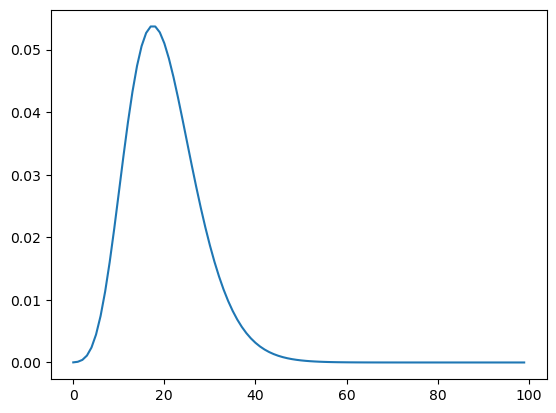

In [36]:
from distributions import dirichlet
from inference.MP_Inference import get_duration_lps
import matplotlib.pyplot as plt

E_dur_n = jnp.zeros(10).at[2].set(1)
prior_p = jnp.ones(2).at[0].set(2) * 1000000 
lps = get_duration_lps(dirichlet.expected_stats(prior_p), E_dur_n, 100)
plt.plot(jnp.exp(lps))